# Main_CNN+Training

In diesem Notebook wird die komplette erzeugungs phase, so wie das Training durchgeführt

# Paper CNN 

In [ ]:
#papaer : https://arxiv.org/pdf/1609.04802.pdf


#AFK SKRIPT Google Colab
"""
function ClickConnect(){

    console.log("Working");
    document.querySelector("#comments > span").click()
}
setInterval(ClickConnect,25000)
"""

## Imports

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras import Model
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D,PReLU, BatchNormalization,Flatten
from keras.layers import UpSampling2D, LeakyReLU,Dense,Input,add

from keras.applications import VGG19
import keras.backend as K


## Configurateion of Network

In [10]:
# in Paper num_res_block = 16
num_res_block= 16

# Number TrainingImages  number_images*6= Training SamplesSamples
#number_images = Images, will be split in 6 samples per Image
number_images = 20

# Sample Size LR
LRsizexy=32

# Sample Size HR with one upsample block 2x, with two upsample blocks 4x
HRsizexy=128

#Epochs Training
epochs = 10

#every x epoch will be saved
saveepoch=2

## Blocks

In [3]:
#Residual block
def res_block(input):
  #k3n64s1 == k3 -> Kernal = (3,3) , n64 ->Neurons = 64 , s-> stride = 1 padding ="same"
  residual_model_layers = Conv2D(64, (3,3), padding = "same")(input)
  residual_model_layers = BatchNormalization(momentum = 0.5)(residual_model_layers)
  residual_model_layers = PReLU(shared_axes = [1,2])(residual_model_layers)
  
  #k3n64s1
  residual_model_layers = Conv2D(64, (3,3), padding = "same")(residual_model_layers)
  residual_model_layers = BatchNormalization(momentum = 0.5)(residual_model_layers)
  resultlayer = add([input,residual_model_layers])
  return resultlayer


#upscale_block
def upscale_block(input):  
  upscale_model_layers = Conv2D(256, (3,3), padding="same")(input)
  upscale_model_layers = UpSampling2D(size = 2 )(upscale_model_layers)
  upscale_model_layers = PReLU(shared_axes=[1,2])(upscale_model_layers)
  return upscale_model_layers

### Generator

In [4]:
#Generator
def build_generatormodel(generator_input, num_res_block=16):
  #k9n64s1
  model_current_layer = Conv2D(64, (9,9), padding="same")(generator_input)
  model_current_layer = PReLU(shared_axes=[1,2])(model_current_layer)
  #druchfluss für addition mit Resblocks
  copy_of_layer = model_current_layer
  # num_res_block = 16 Residualblocks Abbidlung 5
  for i in range(num_res_block):
    model_current_layer = res_block(model_current_layer)
  #k3n64s1 
  model_current_layer = Conv2D(64, (3,3), padding="same")(model_current_layer)
  model_current_layer = BatchNormalization(momentum=0.5)(model_current_layer)
  model_current_layer = add([model_current_layer,copy_of_layer])
  #Zwei Upscalebloecke (Gruen markiert in Abbildung 5)
  model_current_layer = upscale_block(model_current_layer)
  model_current_layer = upscale_block(model_current_layer)
  #k9n3s1
  
  output_layer = Conv2D(3, (9,9), padding="same")(model_current_layer)
  generator_model=Model(inputs=generator_input, outputs=output_layer)
  return generator_model


### Discriminator

In [5]:
#Zum Verbessern der AI wird eine zweite AI genutzt die einen boolean nutzt um herrraus zu finden ob ein bild von einer AI gemacht wurde oder nicht.
def discriminator_block(input, filters, strides=1, batchnormalise=True):
     
    discriminator_model = Conv2D(filters, (3,3), strides = strides, padding="same")(input)
    
    if batchnormalise:
        discriminator_model = BatchNormalization( momentum=0.8)(discriminator_model)
    
    discriminator_model = LeakyReLU( alpha=0.2 )(discriminator_model)
    
    return discriminator_model


#Descriminartor AI
def create_discriminator(discriminator_input_layers):

    dfdiscriminator_filtersize = 64
    discriminator1 = discriminator_block(discriminator_input_layers, dfdiscriminator_filtersize, batchnormalise=False)
    discriminator2 = discriminator_block(discriminator1, dfdiscriminator_filtersize, strides=2)
    discriminator3 = discriminator_block(discriminator2, dfdiscriminator_filtersize*2)
    discriminator4 = discriminator_block(discriminator3, dfdiscriminator_filtersize*2, strides=2)
    discriminator5 = discriminator_block(discriminator4, dfdiscriminator_filtersize*4)
    discriminator6 = discriminator_block(discriminator5, dfdiscriminator_filtersize*4, strides=2)
    discriminator7 = discriminator_block(discriminator6, dfdiscriminator_filtersize*8)
    discriminator8 = discriminator_block(discriminator7, dfdiscriminator_filtersize*8, strides=2)
    discriminator8_flatten = Flatten()(discriminator8)
    discriminator9 = Dense(dfdiscriminator_filtersize*16)(discriminator8_flatten)
    discriminator10 = LeakyReLU(alpha=0.2)(discriminator9)
    validation_layer = Dense(1, activation='sigmoid')(discriminator10)
    result_model = Model(discriminator_input_layers, validation_layer)
    return result_model


### VGG19 for feature extraction

In [ ]:
def vgg(HR_shape):
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=HR_shape)
    vggModel = Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)
    return vggModel

### Combine Models

In [ ]:
def SRResNet(generator_model, discriminator_model, vgg, lr_input, hr_input):
    generated_image = generator_model(lr_input)
    
    gen_features = vgg(generated_image) 
    discriminator_model.trainable = False
    validity = discriminator_model(generated_image)
    SRResNet_Model = Model(inputs=[lr_input, hr_input], outputs=[validity, gen_features])
    return SRResNet_Model

# Datensatz

## Import Images

In [6]:
def extract_pixel_sample(image, x, y, size=128):
    sample = image[y:y+size, x:x+size]
    return sample

### Get Random Samples From Dataset

In [7]:
import random

lr_list=[]
hr_list=[]

randomNR=[]

for x in range(0,number_images):
    randomNR.append( random.randint(0, len(os.listdir("HR_Pic"))-1))


for x in tqdm(randomNR):
    lr_list.append(os.listdir("ULR_Pic")[x])
    hr_list.append(os.listdir("HR_Pic")[x])



100%|██████████| 80/80 [00:01<00:00, 64.29it/s]


In [8]:
lr_images = []


for img in tqdm(lr_list):

    img_lr = cv2.imread("ULR_Pic/" + img,flags= cv2.IMREAD_COLOR)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    
    h,w,c = img_lr.shape
    sample = extract_pixel_sample(img_lr,0,0,size=LRsizexy)
    lr_images.append(sample)

    sample = extract_pixel_sample(img_lr,LRsizexy,LRsizexy,size=LRsizexy)
    lr_images.append(sample)

    sample = extract_pixel_sample(img_lr,LRsizexy*2,LRsizexy*2,size=LRsizexy)
    lr_images.append(sample)


    sample = extract_pixel_sample(img_lr,LRsizexy*3,LRsizexy*3,size=LRsizexy)
    lr_images.append(sample)

    
    sample = extract_pixel_sample(img_lr,LRsizexy*4,LRsizexy*2,size=LRsizexy)
    lr_images.append(sample)

    
    sample = extract_pixel_sample(img_lr,LRsizexy*5,LRsizexy*2,size=LRsizexy)
    lr_images.append(sample)






100%|██████████| 80/80 [00:03<00:00, 25.15it/s]


In [11]:
hr_images = []

for img in tqdm(hr_list):

    img_hr = cv2.imread("HR_Pic/" + img,flags= cv2.IMREAD_COLOR)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    
    h,w,c = img_hr.shape
    sample = extract_pixel_sample(img_hr,0,0,size=HRsizexy)
    hr_images.append(sample)

    sample = extract_pixel_sample(img_hr,HRsizexy,HRsizexy,size=HRsizexy)
    hr_images.append(sample)

    sample = extract_pixel_sample(img_hr,HRsizexy*2,HRsizexy*2,size=HRsizexy)
    hr_images.append(sample)
    
    sample = extract_pixel_sample(img_hr,HRsizexy*3,HRsizexy*3,size=HRsizexy)
    hr_images.append(sample)

    sample = extract_pixel_sample(img_hr,HRsizexy*4,HRsizexy*2,size=HRsizexy)
    hr_images.append(sample)

    sample = extract_pixel_sample(img_hr,HRsizexy*5,HRsizexy*2,size=HRsizexy)
    hr_images.append(sample)





100%|██████████| 80/80 [00:02<00:00, 27.85it/s]


In [12]:
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

## Check Samples

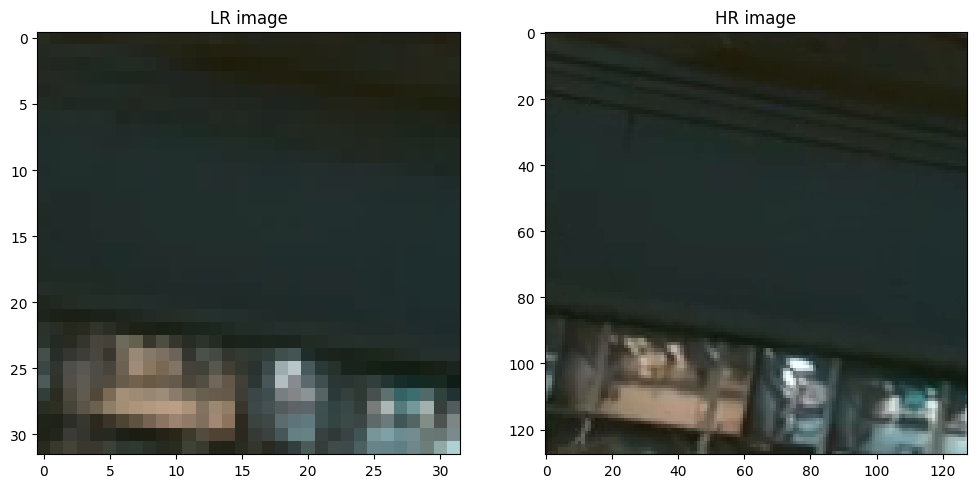

In [13]:
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('LR image')
plt.imshow(np.reshape(lr_images[image_number], (LRsizexy , LRsizexy, 3)))
plt.subplot(122)
plt.title('HR image')
plt.imshow(np.reshape(hr_images[image_number], (HRsizexy, HRsizexy, 3)))
plt.show()


## Normalize und train_test_Split

In [14]:
#Scale values
lr_images = lr_images / 255.0
hr_images = hr_images / 255.0

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.3, random_state=1337)

hr_shape = hr_train.shape[1:]
lr_shape = lr_train.shape[1:]

lr_input = Input(shape=lr_shape)
hr_input = Input(shape=hr_shape)

# Create Model

In [ ]:
#Functions to output .summary() to file

def printGenerator(s):
    with open('generator_sum.txt','a') as f:
        print(s, file=f)

def printDiscriminator(s):
    with open('discriminator_sum.txt','a') as f:
        print(s, file=f)

def printvgg(s):
    with open('vgg_sum.txt','a') as f:
        print(s, file=f)

def printmainModel(s):
    with open('gan_sum.txt','a') as f:
        print(s, file=f)

In [ ]:
generator = build_generatormodel(lr_input, num_res_block = num_res_block)

discriminator = create_discriminator(hr_input)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

generator.summary(print_fn=printGenerator)
discriminator.summary(print_fn=printDiscriminator)

vgg = vgg((HRsizexy,HRsizexy,3))
vgg.summary(print_fn=printvgg)
vgg.trainable = False




In [ ]:
#Combo Modell Generator/ Discriminator
mainModel = SRResNet(generator, discriminator, vgg, lr_input, hr_input)

## Compile

In [ ]:
mainModel.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam", metrics =["mean_squared_error"])
mainModel.summary(print_fn=printmainModel)

## Training Epochs

In [ ]:
def Log(filename, text="LossLog:", mode="w"):
    with open(filename,mode) as f:
        f.write(str(text+"\n"))

#Create Filename for new Training
from datetime import datetime
currentfilename = datetime.today().strftime('%d-%m-%Y_%H-%M-%S_Log.txt')

In [ ]:
batch_size = 1  
train_lr_batches = []
train_hr_batches = []

#create emptyLog.txt
Log(currentfilename)

for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    

for epo in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) 
    real_label = np.ones((batch_size,1)) 
    
    generator_losses = []
    discriminator_losses = []
    

    for batch in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[batch] 
        hr_images = train_hr_batches[batch] 
        
        fake_imgs = generator.predict_on_batch(lr_imgs)
        
        #Descriminator Trainieren 
        discriminator.trainable = True #Trainieren zulassen
        discriminator_loss_generation = discriminator.train_on_batch(fake_imgs, fake_label)
        discriminator_loss_real = discriminator.train_on_batch(hr_images, real_label)
        
        discriminator.trainable = False #Trainieren Blockieren
        
        # Durchscnittlicher Loss aus beiden Versionen
        discriminator_loss = 0.5 * np.add(discriminator_loss_generation, discriminator_loss_real) 
        
        #Feature Map
        image_features = vgg.predict(hr_images)
     
        generator_loss, *_ = mainModel.train_on_batch([lr_imgs, hr_images], [real_label, image_features])
        
        discriminator_losses.append(discriminator_loss)
        generator_losses.append(generator_loss)
         
    generator_losses = np.array(generator_losses)
    discriminator_losses = np.array(discriminator_losses)
    
    generator_loss = np.sum(generator_losses, axis=0) / len(generator_losses)
    discriminator_loss = np.sum(discriminator_losses, axis=0) / len(discriminator_losses)
    
    #Log Loss to File
    Log(currentfilename,text=str("epoch: "+ str(epo+1) +"\tg_loss: "+ str(generator_loss)+ "\td_loss: "+ str(discriminator_loss)), mode="a")


    if (epo+1) % saveepoch == 0:
        generator.save("Model_atEpoch_"+ str(epo+1) +".h5")
        Log(currentfilename,text=str("Saved at Last Epoch"), mode="a")


generator.save("FinishedModel"+".h5")

# Simple Predict Image after Training

## Predict Random Sample after Training

1/1 [==============================] - 1s 743ms/step


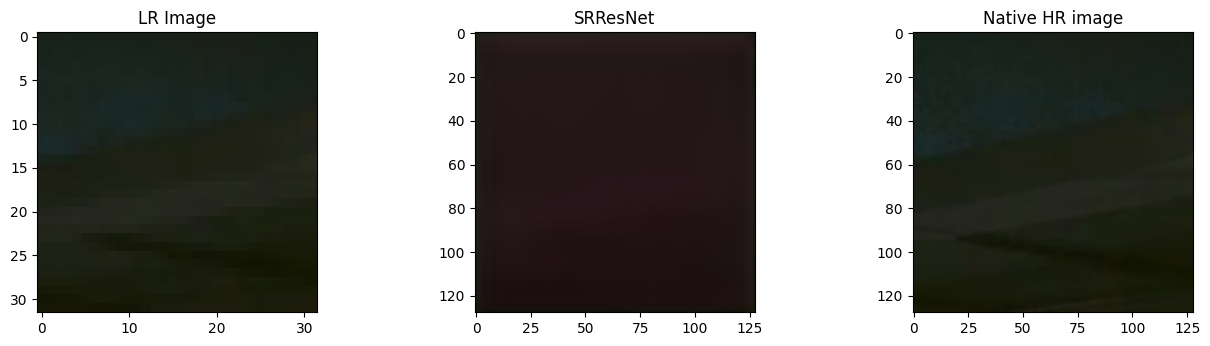

In [21]:
from keras.models import load_model
from numpy.random import randint

modelname='Model_atEpoch_2'
generator = load_model(str(modelname+'.h5'), compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('SRResNet')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Native HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


# [deprecated] Prediction and Render Queue [!!!Use: Prediction+RenderQueue.ipynb for predictions!!!]

In [16]:
#Imports
import os
import cv2
import numpy as np
from numpy.random import randint
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras import Model
from keras.models import load_model
import keras.backend as K

## Configuration

In [17]:
#Model Config
modelname='Model_atEpoch_2'

#Single IMG Prediction Config
LR_IMGPATH="ULR_Pic\\ULR_00000.png"
HR_IMGPATH = "HR_Pic\\HR_00000.png"


#Render Queue Config
INPUT = "Input\\"
PREDICTION = "Prediction\\"

In [31]:
generator = load_model(str(modelname+'.h5'), compile=False)

hr_image =cv2.imread(HR_IMGPATH,flags= cv2.IMREAD_COLOR)
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

def extract_pixel_sample(image, x, y, size=128):
    sample = image[y:y+size, x:x+size]
    return sample
initializesample =[]

initializesample.append(extract_pixel_sample(hr_image,0,0,size=32))
initializesample = np.array(initializesample)
initializesample = initializesample/255.0
newshape=(-1,32,32,3)
initializesample = np.reshape(initializesample,newshape)

generator.predict(initializesample)

1/1 [==============================] - 1s 867ms/step


array([[[[0.10173653, 0.10688915, 0.06992719],
         [0.1084173 , 0.11065647, 0.07602233],
         [0.10809306, 0.1085838 , 0.07858543],
         ...,
         [0.1006234 , 0.10153937, 0.0851955 ],
         [0.09626748, 0.10012482, 0.08267005],
         [0.08128944, 0.09128805, 0.0738527 ]],

        [[0.10420918, 0.10630832, 0.06908453],
         [0.11162849, 0.1100979 , 0.07601482],
         [0.1100923 , 0.10805176, 0.07793461],
         ...,
         [0.10841402, 0.10326263, 0.08329003],
         [0.10464498, 0.10179327, 0.08169423],
         [0.08650523, 0.09175362, 0.0725695 ]],

        [[0.10850625, 0.1044403 , 0.07176457],
         [0.11905695, 0.10795741, 0.07929737],
         [0.11908443, 0.10413415, 0.08017722],
         ...,
         [0.1224371 , 0.09947971, 0.08561137],
         [0.11858229, 0.10001841, 0.0843067 ],
         [0.09658241, 0.08926855, 0.07402085]],

        ...,

        [[0.08958229, 0.08472314, 0.05573706],
         [0.10045739, 0.08507627, 0.05837167]

## Define Score Functions

In [32]:
# PSNR Function and !SSIM Function!
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

## Predict Single Image

1/1 [==============================] - 16s 16s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[23.97362698 23.37939368 23.41903334 ... 27.73109896 24.84612742
   26.4996654 ]
  [24.04252813 23.37327117 23.44545292 ... 26.05756055 29.41396886
   34.18647405]
  [24.01650211 23.21426548 23.3686154  ... 26.15387436 25.66347959
   29.12771055]
  ...
  [27.08693042 27.08104929 27.36248336 ... 26.83480371 26.37248083
   27.45355117]
  [30.24200585 30.44133948 31.00193226 ... 28.66856781 28.14048667
   28.49162641]
  [30.42922948 30.78598399 31.07990103 ... 28.48037316 28.10517452
   28.24821661]]], shape=(1, 1080, 1920), dtype=float64)


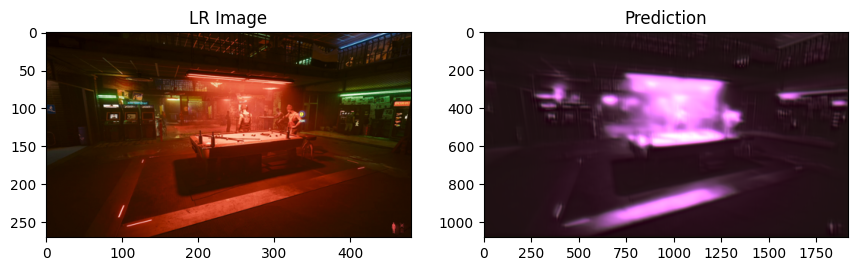

In [33]:
lr_image = cv2.imread(LR_IMGPATH,flags= cv2.IMREAD_COLOR)
lr_image = cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB)
hr_image =cv2.imread(HR_IMGPATH,flags= cv2.IMREAD_COLOR)
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

lr_image = lr_image / 255.0
hr_image = hr_image / 255.0

lr_image = np.expand_dims(lr_image, axis=0)
generated_sreeni_hr = generator.predict(lr_image)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(lr_image[0,:,:,:])
plt.subplot(232)
plt.title('Prediction')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.savefig(str(modelname+".jpg"),bbox_inches ='tight')

print(PSNR(hr_image,generated_sreeni_hr))
plt.show()

## Render Queus

In [ ]:
def predict_X(input_datei, output_datei):

    lr = cv2.imread(input_datei,flags= cv2.IMREAD_COLOR)
    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
    lr = lr / 255.
    lr = np.expand_dims(lr, axis=0)

    generated__hr = generator.predict(lr)


    generated__hr[0,:,:,:] = cv2.imwrite(output_datei,cv2.cvtColor(generated__hr[0,:,:,:]*255,cv2.COLOR_RGB2BGR))


for img in tqdm(os.listdir(INPUT)):
    predict_X(str(INPUT+img) , str(PREDICTION+"HR"+img[3:]))#Change nuber in [] for length of name till number or seperator. Example "ULR_0000" =>[3:] =>"_0000"